In [31]:
! bash setup.sh
! python3 -m pip install --upgrade efficientnet-pytorch
! python3 -m pip install python-telegram-bot

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=f43e21226769c288032a261ccdcf65a838a553edbca15ab0cff8c2d251c5d1a6
  Stored in directory: /home/jovyan/.cache/pip/wheels/1c/07/d1/ff77968842daae1dde944173a8e8a7be193646d37842f13b24
Successfully built efficientnet-pytorch
     |████████████████████████████████| 371 kB 8.1 MB/s eta 0:00:01


In [57]:
# libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torch.utils.data as data

import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO
from build_vocab import Vocabulary
from efficientnet_pytorch import EfficientNet
import random
import matplotlib.pyplot as plt

from telegram import Bot
import argparse

bot = Bot('739462815:AAELJ6hhjzj3zv-3c_dkGkCyUS9vB3G5t90')

class EfficientNetBackbone(EfficientNet):
    def __init__(self, blocks_args=None, global_params=None):
        EfficientNet.__init__(self, blocks_args, global_params)
        self.output_size = self._fc.in_features
        self._fc = None
        
    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
        return x

class EncoderCNN(nn.Module):
    def __init__(self, backbone, backbone_output_dim, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        self.backbone = backbone
        self.linear = nn.Linear(backbone_output_dim, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.backbone(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
#         batch_size, hidden_dim = features.shape
        cell_state = features.unsqueeze(0)
        hidden_state = torch.zeros(cell_state.shape).to(device)
        
        hiddens, _ = self.lstm(packed,(hidden_state,cell_state))
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
#         caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers, collate_fn):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader, coco.coco

def visualise_one(coco, encoder, decoder):
    print('visualise one')
    encoder.eval()
    decoder.eval()
    rand_idx = random.randint(0,len(coco.imgs)-1)
    image_id = list(coco.imgs.keys())[rand_idx]
    string_id = '0'*(6-len(str(image_id)))+str(image_id)
    image = Image.open('../datasets/coco2014/train2014/COCO_train2014_000000{}.jpg'.format(string_id)).convert('RGB')
    
    image = image.resize([224, 224], Image.LANCZOS)
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    feature = encoder(image_tensor)
    cell_state = feature.unsqueeze(0)
    hidden_state = torch.zeros(cell_state.shape).to(device)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption[:-1])
    plt.imshow(image)
    plt.xlabel(sentence)
    plt.savefig('sample.png')
    plt.clf()
    encoder.train()
    decoder.train()

# hyperparams
crop_size=224
vocab_path = 'vocab.pkl'
batch_size = 128
embed_size = 256
hidden_size = 512
learning_rate = 0.001
num_epochs = 5
num_workers = 2
num_layers = 1
log_step = 500
save_step = 1000
image_dir = 'resized2014'
model_path = './models'
train_caption_path = '../datasets/coco2014/trainval_coco2014_captions/captions_train2014.json'
test_caption_path = '../datasets/coco2014/trainval_coco2014_captions/captions_val2014.json'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [58]:
# Train

model_name = 'efficientnetb0-glove.200d-hidden200-connected_hidden'
crop_size=224
vocab_path = 'vocab.pkl'
batch_size = 128
embed_size = 200
hidden_size = 200
learning_rate = 0.001
num_epochs = 5
num_workers = 2
num_layers = 1
log_step = 500
save_step = 3000
visualise_step = 200
# save_step = 200
image_dir = 'resized2014'
model_path = './models'
train_caption_path = '../datasets/coco2014/trainval_coco2014_captions/captions_train2014.json'
test_caption_path = '../datasets/coco2014/trainval_coco2014_captions/captions_val2014.json'

bot.sendMessage(-428968689,'Training {}'.format(model_name))

efficientnetBackbone = EfficientNetBackbone.from_pretrained('efficientnet-b0')

encoder = EncoderCNN(efficientnetBackbone,efficientnetBackbone.output_size,hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

decoder.embed.load_state_dict(torch.load('pretrained/coco2014.glove.6B.200d.pth'))

encoder.train()
decoder.train()

# Create model directory
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Build data loader
train_data_loader, train_coco = get_loader(image_dir, train_caption_path, vocab, 
                         transform, batch_size,
                         shuffle=True, num_workers=num_workers,
                        collate_fn=collate_fn)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Train the models
total_step = len(train_data_loader)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_data_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
            bot.sendMessage(-428968689,'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

        if (i+1) % visualise_step == 0:
            visualise_one(train_coco, encoder, decoder)
            img = open('sample.png','rb')
            bot.sendPhoto(-428968689,img)
        
        # Save the model checkpoints
        if (i+1) % save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                model_path, 'decoder.{}-{}-{}.pth'.format(model_name, epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                model_path, 'encoder.{}-{}-{}.pth'.format(model_name, epoch+1, i+1)))
            

Loaded pretrained weights for efficientnet-b0
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.1926, Perplexity: 9824.4535
visualise one
visualise one
Epoch [0/5], Step [500/3236], Loss: 3.4717, Perplexity: 32.1925
visualise one
visualise one
visualise one
Epoch [0/5], Step [1000/3236], Loss: 3.1801, Perplexity: 24.0493
visualise one
visualise one
Epoch [0/5], Step [1500/3236], Loss: 3.0572, Perplexity: 21.2679
visualise one
visualise one
visualise one
Epoch [0/5], Step [2000/3236], Loss: 2.7838, Perplexity: 16.1811
visualise one
visualise one
Epoch [0/5], Step [2500/3236], Loss: 2.6903, Perplexity: 14.7357
visualise one
visualise one
visualise one
Epoch [0/5], Step [3000/3236], Loss: 2.4596, Perplexity: 11.7006
visualise one
Epoch [1/5], Step [0/3236], Loss: 2.6472, Perplexity: 14.1140
visualise one
visualise one
Epoch [1/5], Step [500/3236], Loss: 2.4550, Perplexity: 11.6464
visualise one
visualise one
visualise on

<Figure size 432x288 with 0 Axes>

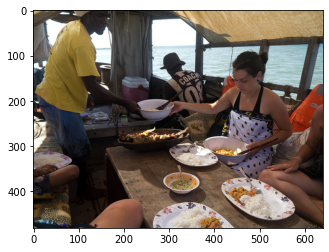

a group of people sitting around a table eating pizza . <end>


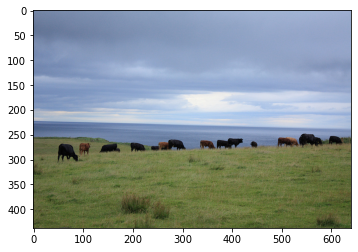

a herd of cattle grazing on a lush green field . <end>


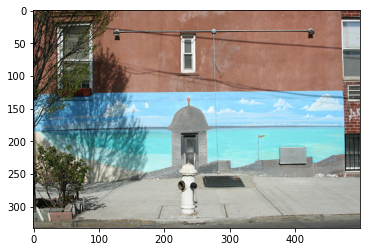

a parking meter on a city street with a building in the background . <end>


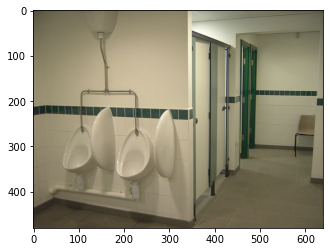

a bathroom with a toilet and a sink . <end>


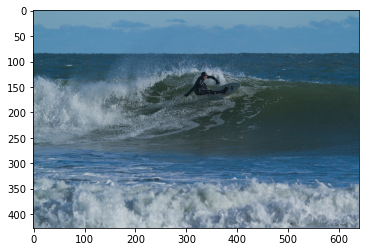

a surfer riding a wave on a surfboard . <end>


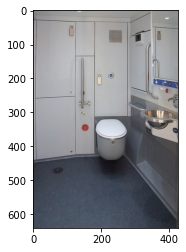

a bathroom with a toilet , sink , and mirror . <end>


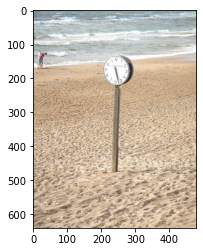

a clock on the side of a sandy beach . <end>


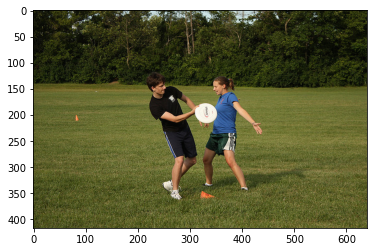

a man and a woman playing frisbee in a park . <end>


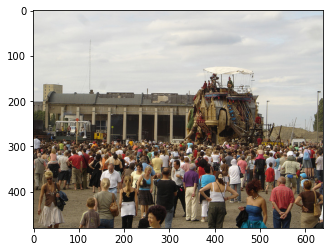

a group of people are gathered around a large elephant . <end>


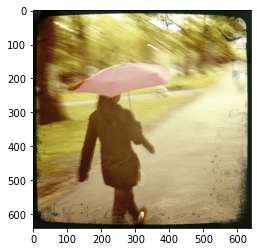

a woman walking down a street holding a umbrella . <end>


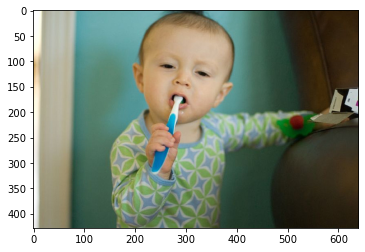

a young boy holding a toothbrush in his mouth . <end>


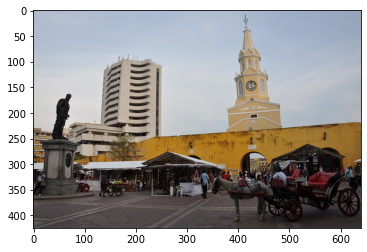

a clock tower is on the side of a building . <end>


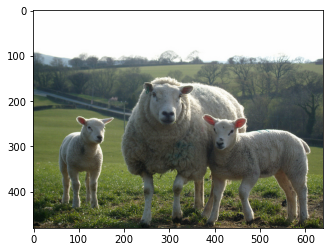

a sheep and a lamb in a field . <end>


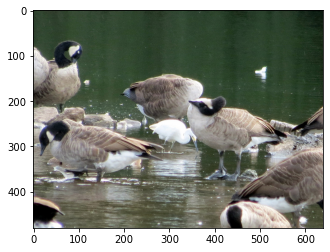

a flock of ducks floating on top of a lake . <end>


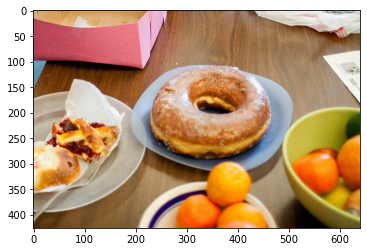

a table with a variety of donuts and a cup of coffee . <end>


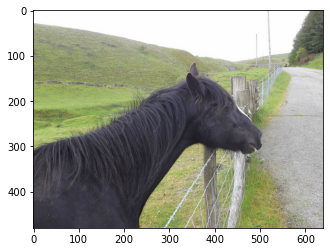

a black horse standing in a field next to a fence . <end>


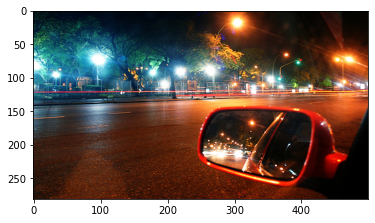

a view of a city street with a traffic light . <end>


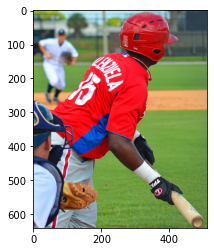

a baseball player is standing on the field . <end>


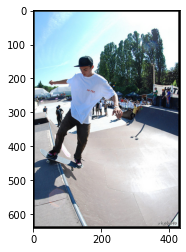

a man riding a skateboard down a street . <end>


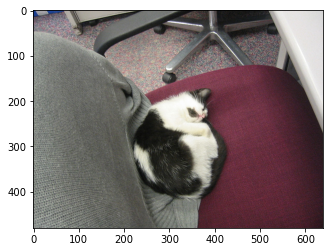

a cat is sitting on a chair in a room . <end>


In [60]:
# Eval
import matplotlib.pyplot as plt

def beam_search(feature,decoder):
    cell_state = feature.unsqueeze(0)
    hidden_state = torch.zeros(cell_state.shape).to(device)

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

# print(torch.load('models/encoder-5-3000.ckpt').keys())

encoder.load_state_dict(torch.load('models/encoder.efficientnetb0-glove.200d-hidden200-connected_cell-5-3000.pth'))
decoder.load_state_dict(torch.load('models/decoder.efficientnetb0-glove.200d-hidden200-connected_cell-5-3000.pth'))

encoder.eval()
decoder.eval()

images = os.listdir('../datasets/coco2014/train2014/')

for i in range(20):
    image = Image.open('../datasets/coco2014/train2014/'+images[i]).convert('RGB')
    plt.imshow(image)
    plt.show()
    
    image = image.resize([224, 224], Image.LANCZOS)
    image = transform(image).unsqueeze(0)
    image_tensor = image.to(device)
    feature = encoder(image_tensor)
    
    cell_state = feature.unsqueeze(0)
    hidden_state = torch.zeros(cell_state.shape).to(device)
    
    sampled_ids = decoder.sample(feature,(hidden_state,cell_state))
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)



In [65]:
# Test
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

encoder.load_state_dict(torch.load('models/encoder.efficientnetb0-glove.200d-hidden200-connected_cell-5-3000.pth'))
decoder.load_state_dict(torch.load('models/decoder.efficientnetb0-glove.200d-hidden200-connected_cell-5-3000.pth'))

encoder.eval()
decoder.eval()

transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

test_data_loader, test_coco = get_loader(image_dir, test_caption_path, vocab, 
                         transform, batch_size,
                         shuffle=True, num_workers=num_workers,
                        collate_fn=collate_fn)

total_bleu_score = 0
count = 0
references = []
sentences = []
chencherry = SmoothingFunction()
for image_id in test_coco.imgs:
    reference = [nltk.tokenize.word_tokenize(cap['caption'].lower()) for cap in test_coco.imgToAnns[image_id]]
    image_id_string = str(image_id)
    image_id_string = '0'*(6-len(image_id_string))+image_id_string
    image = Image.open('../datasets/coco2014/val2014/COCO_val2014_000000{}.jpg'.format(image_id_string)).convert('RGB') 
    image = image.resize([224, 224], Image.LANCZOS)
    image = transform(image).unsqueeze(0)
    image_tensor = image.to(device)
    feature = encoder(image_tensor)
    cell_state = feature.unsqueeze(0)
    hidden_state = torch.zeros(cell_state.shape).to(device)
    
    sampled_ids = decoder.sample(feature,(hidden_state,cell_state))
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
#     sentence = ' '.join(sampled_caption[1:-1])
#     total_bleu_score += sentence_bleu(reference,sampled_caption[1:-1],smoothing_function=chencherry.method1)
    count += 1
    references.append(reference)
    sentences.append(sampled_caption[:-1])
    
    if count % 1000 == 0:
        print('finished: {} images'.format(count))
        break
    
print(corpus_bleu(references,sentences))

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
finished: 1000 images
0.22900457108353817


In [79]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

references = []
for cap in test_coco.imgToAnns[391895]:
    references.append(nltk.tokenize.word_tokenize(cap['caption'].lower()))

print(sentence_bleu(references,references[0]+references[1]))
print(corpus_bleu([references,references],[references[0]+references[1],references[1]+references[1]]))

0.8013621350577493
0.6226914702653821


In [28]:
import shutil
shutil.copy('ImageCaption@James.ipynb','{}.ipynb'.format(model_name))